# Test of algorithms for dimensional reduction

## Basic setup

### Import the library with Ctypes

I wrote the algorithms in a C++ library, which can be called from Python using ctypes

In [23]:
# The following is used to close the library, so it can be loaded again after updating it
handle = lib._handle
del lib
_ctypes.dlclose(handle)

In [1]:
import _ctypes
import ctypes

# Load the library
# The methods below work for me
# lib = ctypes.cdll.LoadLibrary( os.getcwd() + "/../DSAlgorithms/build/libDSAlgorithms.so.1.0.1" )
lib = ctypes.cdll.LoadLibrary( "../DSAlgorithms/build/libDSAlgorithms.so" )

### Import other Python packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Set the default size for the plots with matplotlib
matplotlib.rcParams[ "figure.figsize" ] = [ 10, 6 ]
matplotlib.rcParams[ "figure.dpi" ] = 100


## Principal component analysis

#### Wrappers for the functions written in C++

In [3]:
def PCA_in_Cpp(data, dimReduced=2):
    # Array for the output of the computation in C++
    reducedData = np.zeros( (len(data), dimReduced), dtype=np.double )
    # Make sure that both arrays are contiguous, and that their data type is correct
    if not data.flags["C_CONTIGUOUS"]:
        data = np.ascontiguousarray( data )
    if not reducedData.flags["C_CONTIGUOUS"]:
        reducedData = np.ascontiguousarray( reducedData )
    if not data.dtype == 'float':
        data = data.astype( 'float' )
    if not reducedData.dtype == 'float':
        reducedData = reducedData.astype( 'float' )

    # Setup the types of the arguments of the function
    lib.computePCA.argtypes = [ np.ctypeslib.ndpointer( dtype=ctypes.c_double, flags="C_CONTIGUOUS" ),
                                ctypes.c_int, ctypes.c_int, 
                                np.ctypeslib.ndpointer( dtype=ctypes.c_double, flags="C_CONTIGUOUS" ),
                                ctypes.c_int ]
    # Setup the type of the return value of the function
    # lib.computePCA.restype = None # Void return type
    lib.computePCA.restype = ctypes.POINTER( ctypes.c_double * len(data[0]) * dimReduced )

    # Call the function
    # lib.computePCA( data, len(data), len(data[0]), reducedData, dimReduced )
    mostSignEigenvectors = lib.computePCA( data, len(data), len(data[0]), reducedData, dimReduced )

    # Converthe most significant eigenvectors to a numpy array
    mostSignEigenvectors = np.array( [ [ i for i in eigen ] for eigen in mostSignEigenvectors.contents ] )

    # Return the result of the function
    return reducedData, mostSignEigenvectors

#### Apply it on the `test_temperature.dat` dataset

In [5]:
# Load the dataset
file = open('Datasets/test_temperature.dat')
data = []

for line in file:
    data.append( [] )
    line_aux = line.split( ' ' )
    for i in range( len(line_aux) ):
        # Remove the first (city name) and last (direction) elements of each line
        # if i != 0 and i < len(line_aux) - 1:
        if i != 0 and i < len(line_aux) - 5:
            data[-1].append( float(line_aux[i]) )
data = np.array( data )
file.close()

In [10]:
# Perform PCA on the data
# reducedData, _ = PCA_in_Cpp(data, 2)
reducedData, mostSignEigenvectors = PCA_in_Cpp(data, 2)

Performing PCA on the dataset...


Below I show some plots to view the data projected in the space of these two most significant variables, which I call $(U_1, U_2)$.

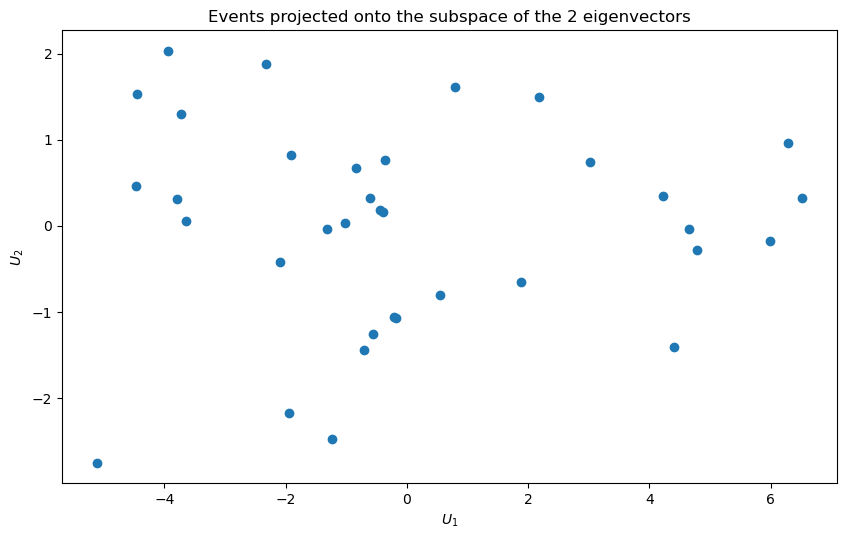

In [11]:
# Plot the results
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set_title('Events projected onto the subspace of the 2 eigenvectors')
ax1.scatter(reducedData[:, 0], reducedData[:, 1])
ax1.set_xlabel(r'$U_1$')
ax1.set_ylabel(r'$U_2$')

plt.show()

Now I plot the projection of the different original features onto the two most significant eigenvectors.
This is, the components of the vector that would correspond to each feature in the reduced plane $(U_1, U_2)$.

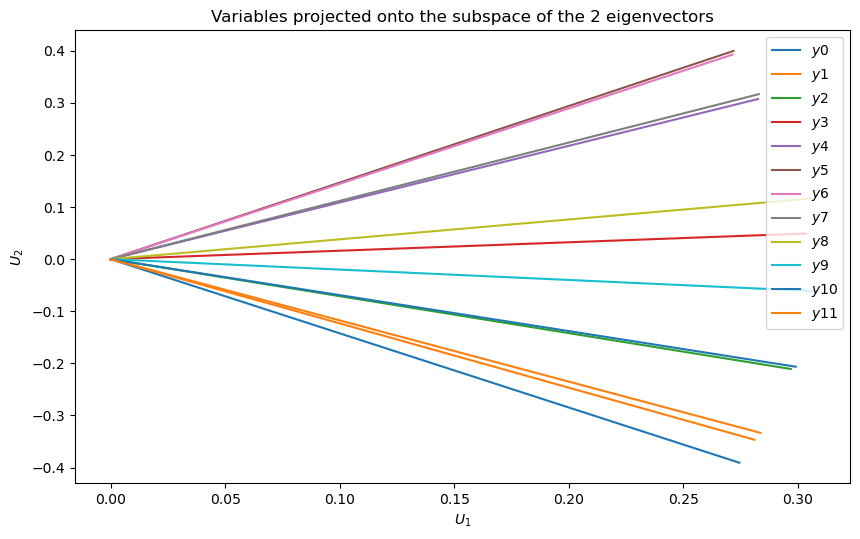

In [12]:
# Plot the projections of the variables in the plane of the two most significant directions

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.set_title("Variables projected onto the subspace of the 2 eigenvectors")
for i in range( len(data[0]) ):
    ax2.plot( [ 0, mostSignEigenvectors[0][i] ],
              [ 0, mostSignEigenvectors[1][i] ], 
              label='$y{}$'.format(i) )

ax2.set_xlabel(r'$U_1$')
ax2.set_ylabel(r'$U_2$')
ax2.legend( loc="best" )
plt.show()


#### Apply it on the `iris.dat` dataset

In [13]:
# Load the dataset
data = np.loadtxt('Datasets/test_iris.dat')
# Take only the first 4 columns.
data = data[:, :4]

In [14]:
# Perform PCA on the data
# reducedData, _ = PCA_in_Cpp(data, 2)
reducedData, mostSignEigenvectors = PCA_in_Cpp(data, 2)

Performing PCA on the dataset...


Below I plot the data projected in the space of these two most significant variables, which I call $(U_1, U_2)$.

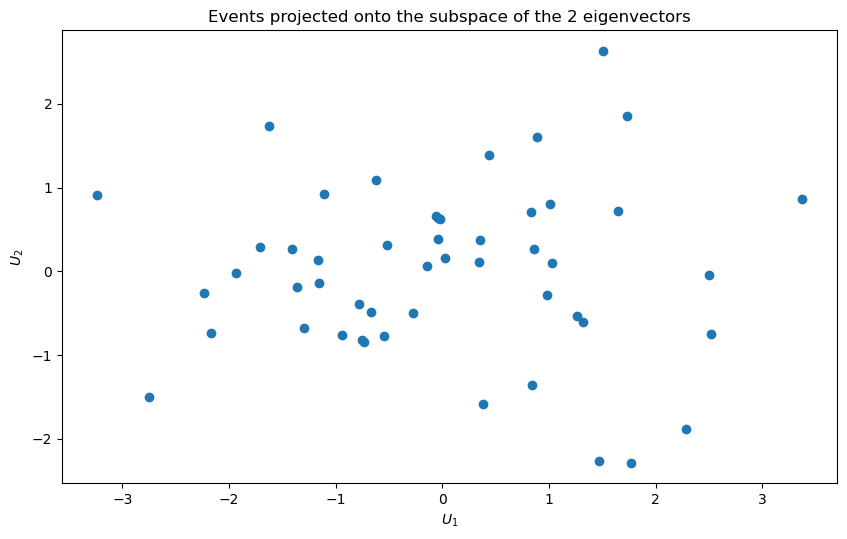

In [15]:
# Plot the results
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set_title('Events projected onto the subspace of the 2 eigenvectors')
ax1.scatter(reducedData[:, 0], reducedData[:, 1])
ax1.set_xlabel(r'$U_1$')
ax1.set_ylabel(r'$U_2$')

plt.show()

Now I plot the projection of the different original features onto the two most significant eigenvectors.
This is, the components of the vector that would correspond to each feature in the reduced plane $(U_1, U_2)$.

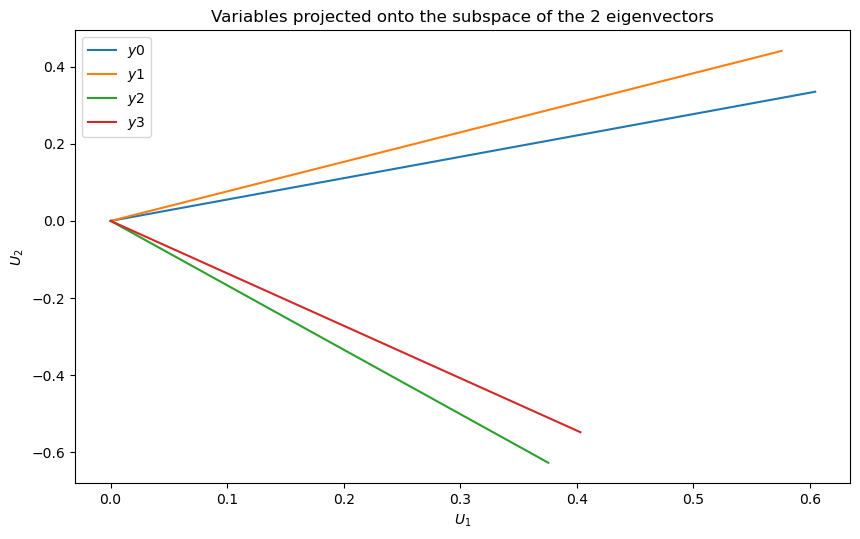

In [16]:
# Plot the projections of the variables in the plane of the two most significant directions

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.set_title("Variables projected onto the subspace of the 2 eigenvectors")
for i in range( len(data[0]) ):
    ax2.plot( [ 0, mostSignEigenvectors[0][i] ],
              [ 0, mostSignEigenvectors[1][i] ], 
              label='$y{}$'.format(i) )

ax2.set_xlabel(r'$U_1$')
ax2.set_ylabel(r'$U_2$')
ax2.legend( loc="best" )
plt.show()


#### Apply it on the iris dataset (full dataset, from Scikit-learn)

In [18]:
# Import the dataset as a pandas dataframe

import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Load the iris dataset from sklearn
iris = load_iris()
# Convert this to a pandas dataframe
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['class'] = iris.target
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [19]:
# Perform PCA on the data
# Notice how I write the argument when calling the function, so it is passed as a numpy array
reducedData, mostSignEigenvectors = PCA_in_Cpp( df.drop(labels='class', axis=1).values, 2)

Performing PCA on the dataset...


Below I plot the data projected in the space of these two most significant variables, which I call $(U_1, U_2)$.

The different colors in the plot correspond to the different classes.

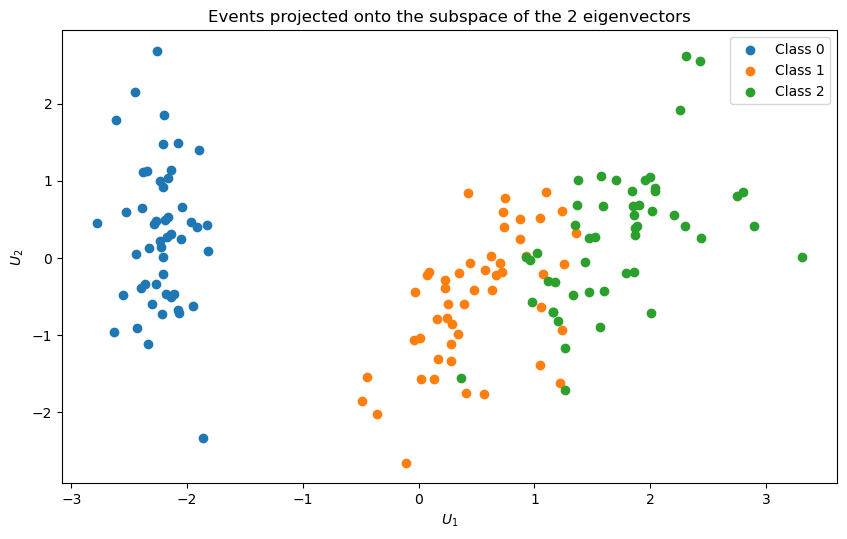

In [20]:
# Plot the results
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set_title('Events projected onto the subspace of the 2 eigenvectors')

# Plot the points corresponding to each class with a different color
for cl in range( max( df['class'].values ) - min( df['class'].values ) + 1 ):
    mask = df['class'] == cl
    ax1.scatter( reducedData[mask, 0], reducedData[mask, 1], label="Class {}".format(cl) )

# ax1.scatter(reducedData[:, 0], reducedData[:, 1])
ax1.set_xlabel(r'$U_1$')
ax1.set_ylabel(r'$U_2$')
ax1.legend(loc='best')

plt.show()

Now I plot the projection of the different original features onto the two most significant eigenvectors.
This is, the components of the vector that would correspond to each feature in the reduced plane $(U_1, U_2)$.

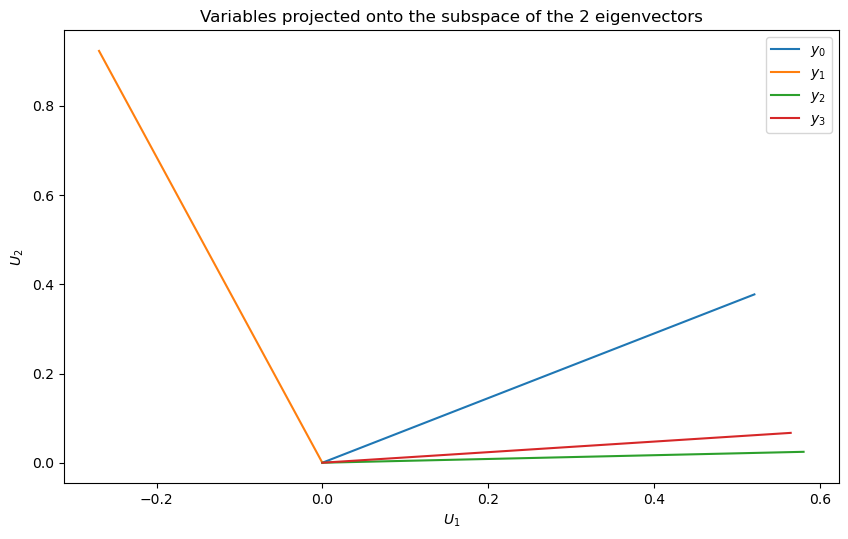

In [21]:
# Plot the projections of the variables in the plane of the two most significant directions

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.set_title("Variables projected onto the subspace of the 2 eigenvectors")
for i in range( len(data[0]) ):
    ax2.plot( [ 0, mostSignEigenvectors[0][i] ],
              [ 0, mostSignEigenvectors[1][i] ], 
              label='$y_{}$'.format(i) )

ax2.set_xlabel(r'$U_1$')
ax2.set_ylabel(r'$U_2$')
ax2.legend( loc="best" )
plt.show()


### Apply it on data generated with several multi-dimensional Gaussians

In [ ]:
# Function to generate the data
def generateDataFromGaussians( nPoints, nGaussians, dim ):

    # Initialize lists for the points and their labels
    points = np.zeros( (nPoints, dim) )
    labels = np.zeros( (nPoints), dtype=int )

    # Generate random means for all the Gaussians and dimensions
    means = np.zeros( (nGaussians, dim) )
    for iGauss in range(nGaussians):
        for iDim in range(dim):
            means[iGauss, iDim] = 2. * np.random.random() - 1.

    # Generate random sigmas
    sigmas = np.zeros( (nGaussians, dim) )
    for iGauss in range(nGaussians):
        for iDim in range(dim):
            sigmas[iGauss, iDim] = 0.5 * np.random.random()

    # Compute the data and labels
    for iPt in range(nPoints):
        # Choose a Gaussian
        iGauss = np.random.randint( nGaussians )
        labels[iPt] = iGauss 
        # Compute the components of the point
        for iDim in range(dim):
            points[iPt, iDim] = np.random.normal( loc=means[iGauss, iDim], scale=sigmas[iGauss, iDim] )

    return points, labels

In [ ]:
# Generate the data
nPoints = 1000
nGaussians = 4
nDim = 4
data, labels = generateDataFromGaussians( nPoints, nGaussians, nDim )

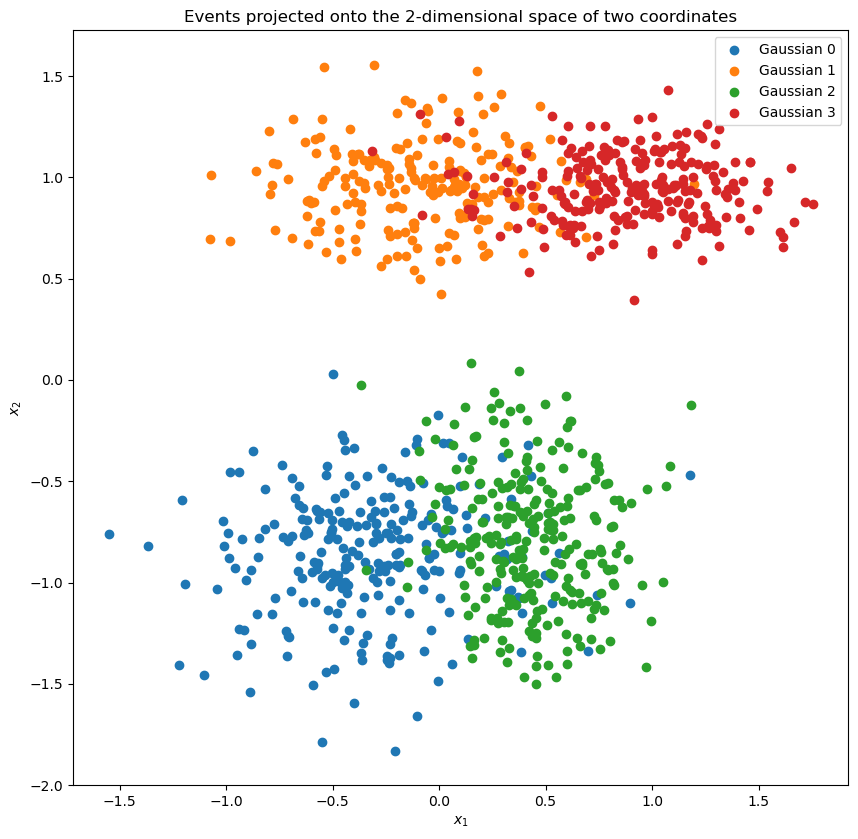

In [ ]:
# Plot a 2-dim projection of the data

# Components to plot
ix = 1
iy = 2

fig = plt.figure( figsize=(10, 10), dpi=100 )
# fig1 = plt.figure()
ax = fig.add_subplot(111)
ax.set_title( 'Events projected onto the 2-dimensional space of two coordinates' )
# Plot the points corresponding to each class with a different color
for cl in range( max(labels) + 1 ):
    mask = labels == cl
    ax.scatter( data[mask, ix], data[mask, iy], label='Gaussian {}'.format(cl) )

ax.set_xlabel(r'$x_{}$'.format(ix))
ax.set_ylabel(r'$x_{}$'.format(iy))
ax.legend(loc='best')

plt.show()

In [11]:
reducedData, _ = PCA_in_Cpp( data, 2)

Performing PCA on the dataset...
Computing the correlation matrix...

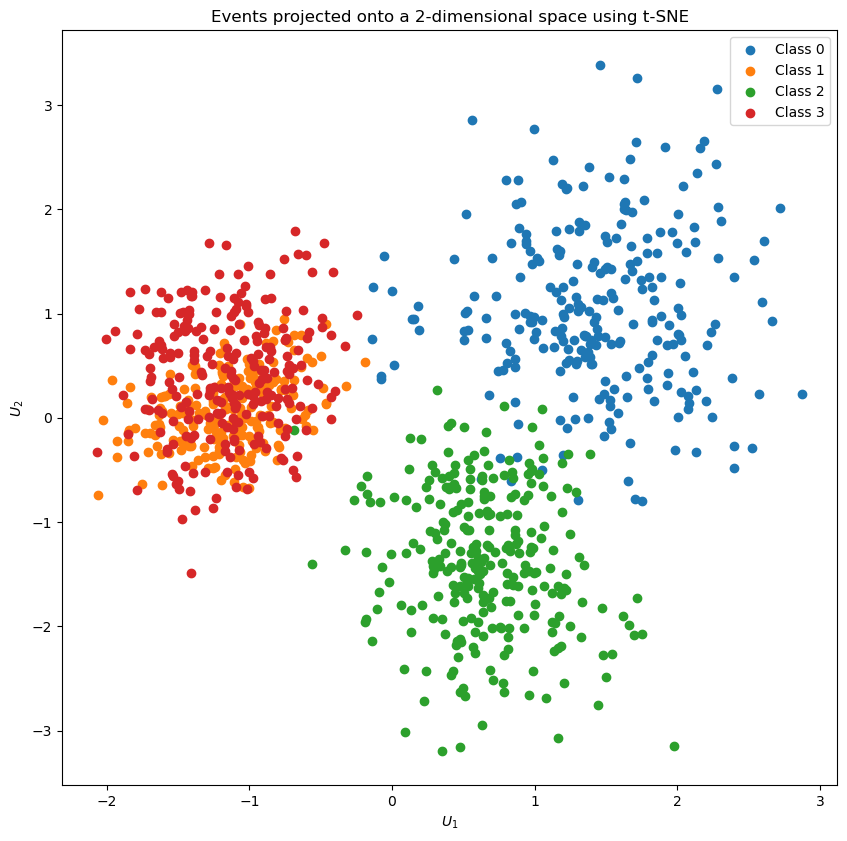

In [ ]:
# Plot the results

fig = plt.figure( figsize=(10, 10), dpi=100 )
ax = fig.add_subplot(111)
ax.set_title( 'Events projected onto a 2-dimensional space using t-SNE' )
# Plot the points corresponding to each class with a different color
for cl in range( max(labels) + 1 ):
    mask = labels == cl
    ax.scatter( reducedData[mask, 0], reducedData[mask, 1], label='Class {}'.format(cl) )

ax.set_xlabel(r'$U_1$')
ax.set_ylabel(r'$U_2$')
ax.legend(loc='best')

plt.show()

## t-SNE

#### Wrappers for the functions written in C++

In [4]:
def tSNE_in_Cpp( dataIn, dimReduced, perpl, gdRate, gdMomentum ):
    # Load the library
    lib = ctypes.cdll.LoadLibrary( "../DSAlgorithms/build/libDSAlgorithms.so" )
    # Array for the output of the computation in C++
    reducedDataOut = np.zeros( (len(dataIn), dimReduced), dtype=np.double )
    # Make sure that both arrays are contiguous, and that their data type is correct
    if not dataIn.flags["C_CONTIGUOUS"]:
        dataIn = np.ascontiguousarray( dataIn )
    if not reducedDataOut.flags["C_CONTIGUOUS"]:
        reducedDataOut = np.ascontiguousarray( reducedDataOut )
    # if not dataIn.dtype == 'float':
    #     dataIn = dataIn.astype( 'float' )
    # if not reducedDataOut.dtype == 'float':
    #     reducedDataOut = reducedDataOut.astype( 'float' )

    # Setup the types of the arguments of the function
    lib.computetSNE.argtypes = [ np.ctypeslib.ndpointer( dtype=ctypes.c_double, flags="C_CONTIGUOUS" ),
                                 ctypes.c_int, ctypes.c_int,
                                 np.ctypeslib.ndpointer( dtype=ctypes.c_double, flags="C_CONTIGUOUS" ),
                                 ctypes.c_int, ctypes.c_double, ctypes.c_double, ctypes.c_double ]
    # Setup the type of the return value of the function
    lib.computetSNE.restype = None # Void return type

    # Call the function
    lib.computetSNE( dataIn, len(dataIn), len(dataIn[0]), reducedDataOut,
                     dimReduced, perpl, gdRate, gdMomentum )

    # Return the result of the function
    return reducedDataOut


#### Apply it on the MNIST dataset

In [6]:
# Load the dataset, with the labels
data = []
with open( 'Datasets/mnist2500_X.txt', 'r' ) as file:
    for line in file:
        line = line.strip().split( "   " )
        data.append( [ float(nr) for nr in line ] )
labels = []
with open( 'Datasets/mnist2500_labels.txt', 'r' ) as file:
    for line in file:
        line = line.strip().split( "   " )[0]
        labels.append( int(float(line) ) )
data = np.array( data, dtype=np.double )
labels = np.array( labels )

# Select only a few of the data points
nPoints = 2500
data = data[ : nPoints ]
labels = labels[ : nPoints ]

In [5]:
# The following is used to close the library, so it can be loaded again after updating it
handle = lib._handle
del lib
_ctypes.dlclose(handle)

In [6]:
import _ctypes
import ctypes

# Load the library
# The methods below work for me
# lib = ctypes.cdll.LoadLibrary( os.getcwd() + "/../DSAlgorithms/build/libDSAlgorithms.so.1.0.1" )
lib = ctypes.cdll.LoadLibrary( "../DSAlgorithms/build/libDSAlgorithms.so" )

In [7]:
# Parameters for t-SNE
nr_dimensions    = 2
perplexity       = 30.
gradientRate     = 500
gradientMomentum = 0.8

# Perform t-SNE on the data
reducedData = tSNE_in_Cpp( data, nr_dimensions, perplexity, gradientRate, gradientMomentum )

Applying t-SNE on the data...
Computing the matrix p_{j|i}... Done.
Minimizing the cost function for t-SNE...
Iteration 0 of 5000, cost function: 22.8972. Previous value of the cost function: 0
Iteration 250 of 5000, cost function: 16.0344. Previous value of the cost function: 16.0316
Iteration 500 of 5000, cost function: 16.0445. Previous value of the cost function: 16.0517
Iteration 750 of 5000, cost function: 1.2886. Previous value of the cost function: 1.28925
Iteration 1000 of 5000, cost function: 1.18943. Previous value of the cost function: 1.18968
Iteration 1250 of 5000, cost function: 1.14355. Previous value of the cost function: 1.14368
Iteration 1500 of 5000, cost function: 1.11572. Previous value of the cost function: 1.11581
Iteration 1750 of 5000, cost function: 1.09686. Previous value of the cost function: 1.09692
Iteration 2000 of 5000, cost function: 1.08305. Previous value of the cost function: 1.0831
Iteration 2250 of 5000, cost function: 1.07248. Previous value of t

Below I show some plots to view the data projected in the space of these two most significant variables, which I call $(U_1, U_2)$.

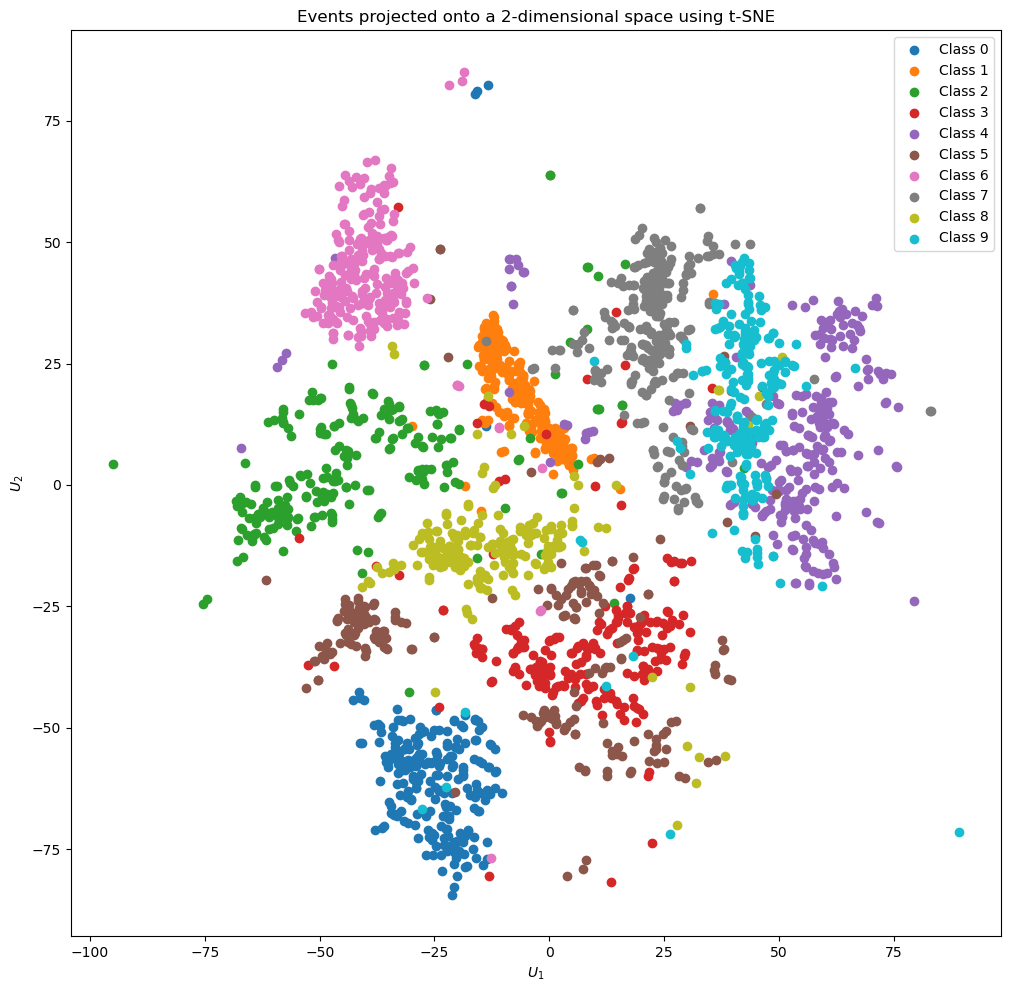

In [10]:
# Plot the results

fig1 = plt.figure( figsize=(12, 12), dpi=100 )
ax1 = fig1.add_subplot(111)
ax1.set_title( 'Events projected onto a 2-dimensional space using t-SNE' )
# Plot the points corresponding to each class with a different color
for cl in range( max(labels) + 1 ):
    mask = labels == cl
    ax1.scatter( reducedData[mask, 0], reducedData[mask, 1], label='Class {}'.format(cl) )

ax1.set_xlabel(r'$U_1$')
ax1.set_ylabel(r'$U_2$')
ax1.legend(loc='best')

plt.show()


### Apply it on data generated with several multi-dimensional Gaussians

In [ ]:
# Function to generate the data

def generateDataFromGaussians( nPoints, nGaussians, dim ):

    # Initialize lists for the points and their labels
    points = np.zeros( (nPoints, dim) )
    labels = np.zeros( (nPoints), dtype=int )

    # Generate random means for all the Gaussians and dimensions
    means = np.zeros( (nGaussians, dim) )
    for iGauss in range(nGaussians):
        for iDim in range(dim):
            means[iGauss, iDim] = 2. * np.random.random() - 1.

    # Generate random sigmas
    sigmas = np.zeros( (nGaussians, dim) )
    for iGauss in range(nGaussians):
        for iDim in range(dim):
            sigmas[iGauss, iDim] = 0.5 * np.random.random()

    # Compute the data and labels
    for iPt in range(nPoints):
        # Choose a Gaussian
        iGauss = np.random.randint( nGaussians )
        labels[iPt] = iGauss 
        # Compute the components of the point
        for iDim in range(dim):
            points[iPt, iDim] = np.random.normal( loc=means[iGauss, iDim], scale=sigmas[iGauss, iDim] )

    return points, labels

In [ ]:
# Generate the data
nPoints = 1000
nGaussians = 4
nDim = 4
data, labels = generateDataFromGaussians( nPoints, nGaussians, nDim )

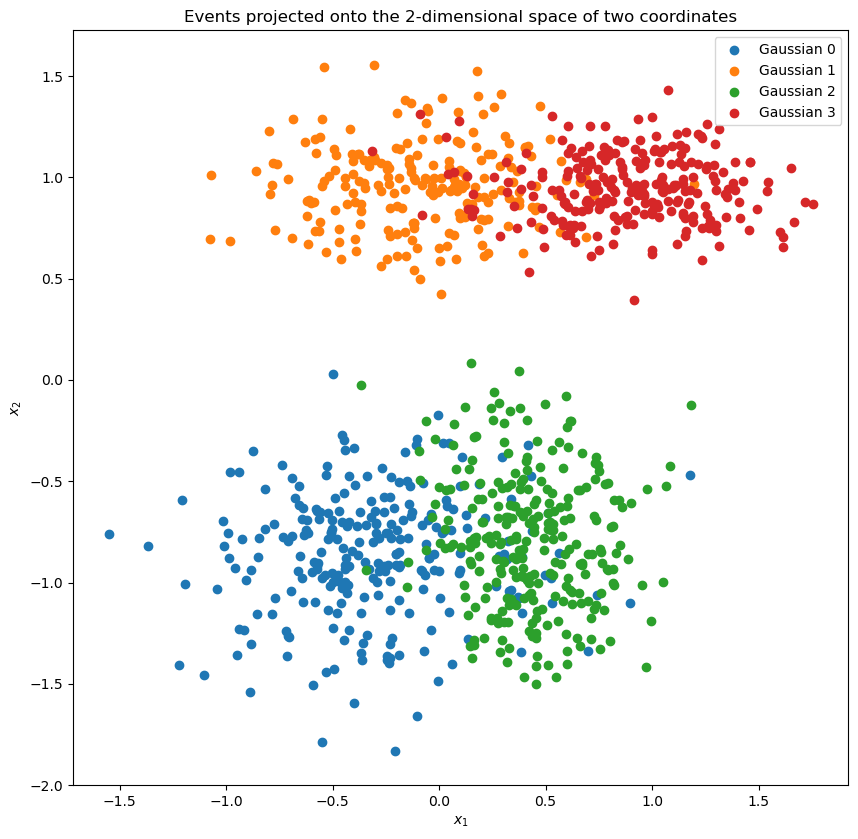

In [ ]:
# Plot a 2-dim projection of the data

# Components to plot
ix = 1
iy = 2

fig = plt.figure( figsize=(10, 10), dpi=100 )
# fig1 = plt.figure()
ax = fig.add_subplot(111)
ax.set_title( 'Events projected onto the 2-dimensional space of two coordinates' )
# Plot the points corresponding to each class with a different color
for cl in range( max(labels) + 1 ):
    mask = labels == cl
    ax.scatter( data[mask, ix], data[mask, iy], label='Gaussian {}'.format(cl) )

ax.set_xlabel(r'$x_{}$'.format(ix))
ax.set_ylabel(r'$x_{}$'.format(iy))
ax.legend(loc='best')

plt.show()

In [ ]:
# Parameters for t-SNE
nr_dimensions    = 2
perplexity       = 30.
gradientRate     = 500
gradientMomentum = 0.8

# Perform t-SNE on the data
reducedData = tSNE_in_Cpp( data, nr_dimensions, perplexity, gradientRate, gradientMomentum )

Applying t-SNE on the data...
Computing the matrix p_{j|i}... Done.

Minimizing the cost function for t-SNE...
Iteration 0 of 5000, cost function: 19.5096. Previous value of the cost function: 0
Iteration 250 of 5000, cost function: 13.2716. Previous value of the cost function: 13.1778
Iteration 500 of 5000, cost function: 13.1649. Previous value of the cost function: 13.1286
Iteration 750 of 5000, cost function: 0.780185. Previous value of the cost function: 0.780348
Iteration 1000 of 5000, cost function: 0.755791. Previous value of the cost function: 0.75585
Iteration 1250 of 5000, cost function: 0.745139. Previous value of the cost function: 0.74517
Iteration 1500 of 5000, cost function: 0.739026. Previous value of the cost function: 0.739045
Iteration 1750 of 5000, cost function: 0.735019. Previous value of the cost function: 0.735032
Iteration 2000 of 5000, cost function: 0.732177. Previous value of the cost function: 0.732187
Iteration 2250 of 5000, cost function: 0.730026. Previ

Below I show some plots to view the data projected in the space of these two most significant variables, which I call $(U_1, U_2)$.

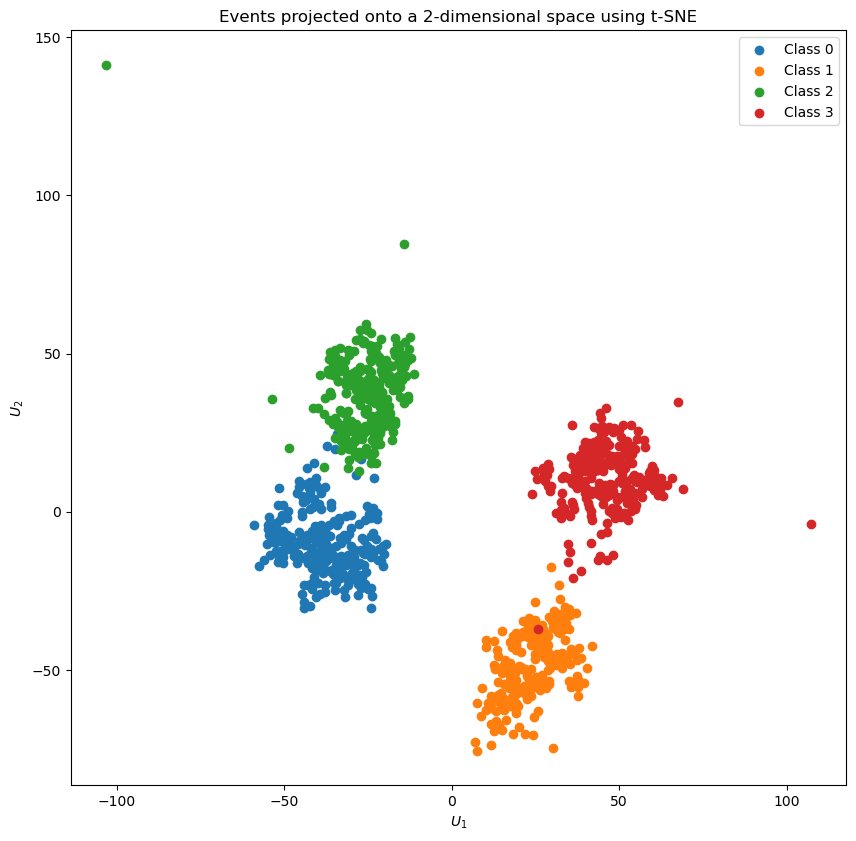

In [ ]:
# Plot the results

fig = plt.figure( figsize=(10, 10), dpi=100 )
ax = fig.add_subplot(111)
ax.set_title( 'Events projected onto a 2-dimensional space using t-SNE' )
# Plot the points corresponding to each class with a different color
for cl in range( max(labels) + 1 ):
    mask = labels == cl
    ax.scatter( reducedData[mask, 0], reducedData[mask, 1], label='Class {}'.format(cl) )

ax.set_xlabel(r'$U_1$')
ax.set_ylabel(r'$U_2$')
ax.legend(loc='best')

plt.show()
